# Overview

In this lab we will use the [COVID-19 Open Research Dataset] that includes scholarly articles with abstracts and full article text to perform exploratory analysis and various other consistency checks to gain a deep understanding of the data and ensure a level of quality that makes it fit for Machine Learning. We will also look at a technique to prepare and transform the data to numerical form that is suitable for Machine Learning task of document classification.

[COVID-19 Open Research Dataset]: https://azure.microsoft.com/en-us/services/open-datasets/catalog/covid-19-open-research/

## Setup

**Import required libraries**

In [0]:
import pandas as pd
import numpy as np
import datetime
import os
import math
import timeit
from io import StringIO
import re
import urllib.request, json
import scipy.stats as s_stats

print("pandas version: {} numpy version: {}".format(pd.__version__, np.__version__))

import nltk
print("nltk version: {}".format(nltk.__version__))

%config InlineBackend.figure_format = 'retina'
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

print("matplotlib version: {} seaborn version: {}".format(matplotlib.__version__, sns.__version__))

pandas version: 1.2.4 numpy version: 1.20.1
nltk version: 3.5
matplotlib version: 3.4.2 seaborn version: 0.11.1

**Download required data for the NLTK package**

In [0]:
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('brown')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data] Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data] Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data] Unzipping corpora/brown.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data] Unzipping help/tagsets.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data] /root/nltk_data...
[nltk_data] Unzipping taggers/averaged_perceptron_tagger.zip.
Out[2]: True

**Helper function to generate summary of missing values in a given pandas dataframe**

In [0]:
def get_missing_summary(df_in):
    missing_df = df_in.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['variable', 'missing values']
    missing_df['filling factor (%)']=(df_in.shape[0]-missing_df['missing values'])/df_in.shape[0]*100
    missing_df['filling factor (%)'] = missing_df['filling factor (%)'].round(2)
    missing_df.sort_values('filling factor (%)').reset_index(drop = True)
    return missing_df

**Location of the data files**

- Metadata file for the COVID-19 Open Research Dataset articles
- Select COVID-19 Open Research Dataset articles that will be used in this notebook

In [0]:
metadata_url = ('https://solliancepublicdata.blob.core.windows.net/ai-in-a-day/'
                'shared/COVID19_Open_Research_Dataset/metadata.csv')

articles_base_url = ('https://solliancepublicdata.blob.core.windows.net/ai-in-a-day/'
                     'shared/COVID19_Open_Research_Dataset/articles/')

## Load and review the metadata for the COVID-19 Open Research Dataset

**Load the metadata in a dataframe**

In [0]:
metadata = pd.read_csv(metadata_url)

/databricks/python/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
 has_raised = await self.run_ast_nodes(code_ast.body, cell_name,

**Check the size of the metadata: `number of rows`**

In [0]:
print(len(metadata))

134206

**List the columns in the metadata**

In [0]:
metadata.columns

Out[7]: Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
 'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
 'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
 'url', 's2_id'],
 dtype='object')

**Review the top 5 entries in the metadata**

In [0]:
display(metadata.head(5))

cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,"Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia",10.1186/1471-2334-1-6,PMC35282,1.1472636E7,no-cc,"OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%) had comorbidities. Twenty-four isolates (60%) were associated with pneumonia, 14 (35%) with upper respiratory tract infections, and 2 (5%) with bronchiolitis. Cough (82.5%), fever (75%), and malaise (58.8%) were the most common symptoms, and crepitations (60%), and wheezes (40%) were the most common signs. Most patients with pneumonia had crepitations (79.2%) but only 25% had bronchial breathing. Immunocompromised patients were more likely than non-immunocompromised patients to present with pneumonia (8/9 versus 16/31, P = 0.05). Of the 24 patients with pneumonia, 14 (58.3%) had uneventful recovery, 4 (16.7%) recovered following some complications, 3 (12.5%) died because of M pneumoniae infection, and 3 (12.5%) died due to underlying comorbidities. The 3 patients who died of M pneumoniae pneumonia had other comorbidities. CONCLUSION: our results were similar to published data except for the finding that infections were more common in infants and preschool children and that the mortality rate of pneumonia in patients with comorbidities was high.",2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,null,null,null,document_parses/pdf_json/d1aafb70c066a2068b02786f8929fd9c900897fb.json,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC35282/,null
02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in lung disease?,10.1186/rr14,PMC59543,1.1667967E7,no-cc,"Inflammatory diseases of the respiratory tract are commonly associated with elevated production of nitric oxide (NO•) and increased indices of NO• -dependent oxidative stress. Although NO• is known to have anti-microbial, anti-inflammatory and anti-oxidant properties, various lines of evidence support the contribution of NO• to lung injury in several disease models. On the basis of biochemical evidence, it is often presumed that such NO• -dependent oxidations are due to the formation of the oxidant peroxynitrite, although alternative mechanisms involving the phagocyte-derived heme proteins myeloperoxidase and eosinophil peroxidase might be operative during conditions of inflammation. Because of the overwhelming literature on NO• generation and activities in the respiratory tract, it would be beyond the scope of this commentary to review this area comprehensively. Instead, it focuses on recent evidence and concepts of the presumed contribution of NO• to inflammatory diseases of the lung.",2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cross, Carroll E",Respir Res,null,null,null,document_parses/pdf_json/6b0567729c2143a66d737eb0a2f63f2dce2e5a7d.json,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC59543/,null
ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-

**Review the summary of missing values by each column in the metadata**

This summary gives us an idea of how complete is the metadata. For example, there are only 30 (0.02%) missing entries of the article titles, whereas, there are 28641 (21%) missing entries for the article abstract.

In [0]:
get_missing_summary(metadata)

Out[9]:

,variable,missing values,filling factor (%)
0,cord_uid,0,100.00
1,sha,77244,42.44
2,source_x,0,100.00
3,title,30,99.98
4,doi,29486,78.03
5,pmcid,73435,45.28
6,pubmed_id,31889,76.24
7,license,0,100.00
8,abstract,28641,78.66
9,publish_time,12,99.99


## Select journal articles that use specific pharses realted to the COVID-19 Pandemic

For this lab, we are going to look at a subset of the metadata to look at journal articles that use specific phrases in their abstracts, for example `“COVID ... Pandemic”` or `“Corona ... Pandemic”`. 

Run the cell below to generate a subset of the metadata (`covid_metadata`) to review in details.

In [0]:
def is_covid(x):
    ans = re.findall(r'(\s*covid|\s*corona)(\w*\s*pandemic)', x, re.IGNORECASE)
    if len(ans) > 0:
        return True
    return False

metadata = metadata[(metadata.pdf_json_files.notnull()) & 
                    (metadata.abstract.notnull()) & 
                    (metadata.journal.notnull())]

metadata.loc[:, 'is_covid'] = metadata['abstract'].apply(lambda x: is_covid(x))

covid_metadata = metadata[metadata.is_covid]
abstracts = covid_metadata.abstract.values

len(abstracts)

Out[10]: 72

Read the first abstract from the `covid_metadata` and observe the phrase `“novel coronavirus pandemic”`.

In [0]:
print(abstracts[0])

OBJECTIVE: The novel coronavirus pandemic is ravaging throughout the world. It has infected more than 1.2 million people and killed more than 64,000. Frantic research is underway to find prevention and cure. Of late, Bacillus Calmette–Guérin (BCG) has been speculated as a possible protection from COVID-19. We sought to investigate the evidence behind the claim. MATERIAL AND METHODS: Data were collected regarding the total number of COVID-19 cases per million and total number of COVID-19 deaths per million in various countries. The BCG vaccination policies of these countries were also obtained. RESULTS: It was seen that the countries with no universal BCG policy had a mean 1272.9 (median 795) cases per million and 80.7 deaths (median 18) per million population. On the contrary, the countries with a universal BCG vaccination policy had a mean 131.2 (median 40) cases per million and 4 deaths (median 1) per population. The difference is highly significant (P < 0.001). CONCLUSION: The data strongly support the hypothesis that BCG may offer protection from COVID-19. Heterologous protection offered by BCG through production of trained immunity, epigenetic reprogramming of monocytes, non-specific activation of NK cells, and increase of pro-inflammatory cytokines (particularly, tumor necrosis factor [TNF]-alpha and interleukin 1 beta) production may be the mechanism behind its cross- protection against the novel coronavirus.

### Distribution of Abstract Word Lengths

Run the next two cells to understand the distribution of abstract word lengths. As you can see from the graph that the word lengths are skewed to the right and has a heavy tail/outliers relative to a normal distribution. Quantitively we can use the skewness and kurtosis metric to measure the characteristics of the distribution -  positive values for the skewness indicate data that are skewed right and high kurtosis tend to have heavy tails, or outliers.

Out[12]:

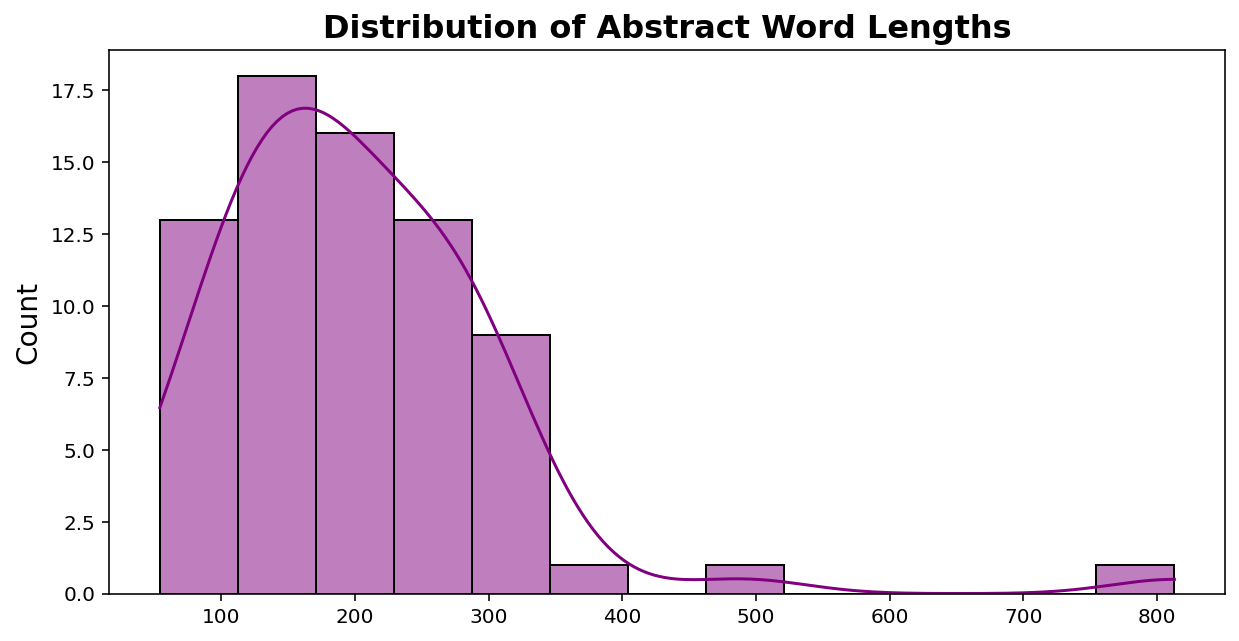

Text(0.5, 1.0, 'Distribution of Abstract Word Lengths')

In [0]:
abstract_nwords = list(map(len, map(nltk.word_tokenize, abstracts)))
f, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=abstract_nwords, ax=ax, kde=True, color='purple')
ax.set_ylabel("Count", fontsize=14);
ax.set_title("Distribution of Abstract Word Lengths", fontsize=16, weight='bold')

In [0]:
from scipy import stats as s_stats
print(s_stats.describe(abstract_nwords))

DescribeResult(nobs=72, minmax=(54, 813), mean=203.54166666666666, variance=12197.68838028169, skewness=2.534343296614634, kurtosis=11.366263510165952)

## Load and review article structure from covid_metadata

The individual article URL is constructed as follows: articles_base_url + `article sha value` + '.json'

Note that the article `sha` values are not clean and some of the entries have two sha values seperated by ';'. If there are multiple `sha` values for an article, we will use the first one to load the article. Run the next two cells to load the articles data.

In [0]:
print(covid_metadata.sha.values[35:40])

['e445c3e34c25ecdb716bc4afec04a57ed8e6e686'
 '8c700541878caab6db1da8743bc579373e3111f7'
 'd6ab189fde7c7f5aa9e0bef7074a74857396f5d9; 2d658bbdcbf5903f59952843897a5b43d7eb96c9'
 '4f6e4abaea32baeb6230479ab679916defb85de7'
 '4799c0512ecbf9fce0eb0371a8ba628082178a33']

In [0]:
articles = []
article_file_names = [f.split(';')[0] for f in covid_metadata.sha.values]
for article_file_name in article_file_names:
    file_url = articles_base_url + article_file_name + '.json'
    with urllib.request.urlopen(file_url) as url:
        article = json.loads(url.read().decode())
    articles.append(article)
print(len(articles))

72

### Review article JSON structure

**Pretty print an article JSON data**

We are interested in how to access the full article text. Observe that an article comprises of a collection of sections under the node: `body_text` and each section has it's text under the node: `text`.

In [0]:
print(json.dumps(articles[0], indent=2, sort_keys=False))

{
 "paper_id": "33a2e1453144e432f8b2c933c09d016b41186439",
 "metadata": {
 "title": "Does the Bacillus Calmette-Gu\u00e9rin vaccine provide protection from COVID-19?",
 "authors": [
 {
 "first": "Soumya",
 "middle": [],
 "last": "Roy",
 "suffix": "",
 "affiliation": {},
 "email": ""
 }
 ]
 },
 "abstract": [],
 "body_text": [
 {
 "text": "Data on the \"total number of COVID-19 cases per 1 million population\" and \"total number of COVID-19 deaths per 1 million population\" of different countries were obtained from an online source. [1] Data on the \"BCG policy, \" \"incidence of TB/1,000,000 population, \" and the \"income group according to World Bank data\" of these countries were obtained from another online source. Countries with a total case fatality 20 (on the date of the study) were included. [3] The countries were divided into two groups: Group A containing the countries \"where universal BCG policy is in practice at present\" and Group B containing the countries \"where universal BCG policy is not practiced at present. \" We compared the \"total number of COVID-19 cases per 1 million population\" as well as the \"total number of deaths per 1 million population\" between Groups A and B to look for any statistical significance. Subsequently, we divided the countries with \"no universal BCG policy\" into two groups: Group C containing the countries where \"universal BCG policy was previously present, but has now been stopped\" and Group D containing the countries where \"universal BCG policy was never present. \" The number of COVID-19 cases per 1 million population in Group C and Group D was compared to look for any statistically significant difference. Similarly, the number of deaths per million was also compared between Groups C and D. Eventually, we grouped all the countries into two groups: The first group (Group E) comprising \"countries where incidence of tuberculosis is \u226420/1,000,000, \" i.e., countries with low incidence of tuberculosis and the second group (Group F) comprising nations \"where the incidence of tuberculosis is >20/1,000,000, \" i.e. countries with higher incidence of tuberculosis). We compared the \"total number of COVID-19 cases per 1 million population\" as well as the \"total number of deaths per 1 million population\" between Groups E and F.",
 "cite_spans": [
 {
 "start": 193,
 "end": 196,
 "text": "[1]",
 "ref_id": "BIBREF0"
 },
 {
 "start": 460,
 "end": 463,
 "text": "[3]",
 "ref_id": null
 }
 ],
 "ref_spans": [],
 "section": "MATERIAL AND METHODS"
 },
 {
 "text": "The data in the two groups were tested for statistical significance using the Mann-Whitney U-test. An online software was used to analyze the data available at http://www. statskingdom.com/170median_mann_whitney.html.",
 "cite_spans": [],
 "ref_spans": [],
 "section": "Statistical analysis"
 },
 {
 "text": "At the time of the study, 50 countries had a total COVID-19 deaths of \u226520. Out of these, 21 countries do not have a universal BCG vaccination policy at present, whereas 29 countries have it. Out of the 21 countries with no universal BCG policy, 20 countries are from high-income group and one country is from upper middle-income group. Out of the 29 countries with universal BCG vaccination, 7 are from high income, 15 are from upper middle, and 7 are from lower middle-income group. The countries where universal BCG vaccination is not practiced have a mean COVID-19 positive cases of 1272.9 (standard deviation 1557.9) per 1 million population with a median of 795. The countries where universal BCG vaccination is practiced have a mean COVID-19 positive cases of 131.1 (standard deviation 208.7) per 1 million population with a median of 40. The difference is statistically significant (P < 0.001) [ Figure 1a ]. The countries where universal BCG vaccination is not practiced have a mean COVID-19 deaths of 80.7 (standard deviation 180.8) per 1 million population with a median of 18. The countries where universal BCG vaccination 

**Understand how to access article text elements**

How to access the `text` element from the first section of an article?

In [0]:
print(articles[0]['body_text'][0]['text'])

Data on the "total number of COVID-19 cases per 1 million population" and "total number of COVID-19 deaths per 1 million population" of different countries were obtained from an online source. [1] Data on the "BCG policy, " "incidence of TB/1,000,000 population, " and the "income group according to World Bank data" of these countries were obtained from another online source. Countries with a total case fatality 20 (on the date of the study) were included. [3] The countries were divided into two groups: Group A containing the countries "where universal BCG policy is in practice at present" and Group B containing the countries "where universal BCG policy is not practiced at present. " We compared the "total number of COVID-19 cases per 1 million population" as well as the "total number of deaths per 1 million population" between Groups A and B to look for any statistical significance. Subsequently, we divided the countries with "no universal BCG policy" into two groups: Group C containing the countries where "universal BCG policy was previously present, but has now been stopped" and Group D containing the countries where "universal BCG policy was never present. " The number of COVID-19 cases per 1 million population in Group C and Group D was compared to look for any statistically significant difference. Similarly, the number of deaths per million was also compared between Groups C and D. Eventually, we grouped all the countries into two groups: The first group (Group E) comprising "countries where incidence of tuberculosis is ≤20/1,000,000, " i.e., countries with low incidence of tuberculosis and the second group (Group F) comprising nations "where the incidence of tuberculosis is >20/1,000,000, " i.e. countries with higher incidence of tuberculosis). We compared the "total number of COVID-19 cases per 1 million population" as well as the "total number of deaths per 1 million population" between Groups E and F.

### Construct the full article text from individual sections

Next we are going to create the articles collection that has the full text for each article. As we are building this collection, we are also going to detect the article language and only add articles that are in **English** to our collection. Note that there were 7 articles that were either in German or Spanish that were not added to our collection.

In [0]:
from langdetect import detect

articles_body = []

for article in articles:
    sample_text = article['body_text'][0]['text']
    lang = detect(sample_text)
    if lang == 'en':
        article_sections = []
        for body_text in article['body_text']:
            article_sections.append(body_text['text'])
        article_body = ' '.join([section for section in article_sections])
        articles_body.append(article_body)
    else:
        print(lang + ': ' + sample_text[0:50] + '...')

de: Hintergrund Die Pandemie mit dem neuen Coronavirus...
es: perspectivas clínicas de una serie de casos....
es: EL Registro comenzó a funcionar el 18 de marzo de ...
de: Hintergrund Seit den ersten beschriebenen Verdacht...
es: La reciente aparición de la pandemia por el corona...
de: Spätestens seit März 2020 ist das Coronavirus auch...
de: » Der TCM/Akupunktur kommt eine allgemein-unterstü...

**Print and read the first article in the collection**

In [0]:
articles_body[0]

Out[19]: 'Data on the "total number of COVID-19 cases per 1 million population" and "total number of COVID-19 deaths per 1 million population" of different countries were obtained from an online source. [1] Data on the "BCG policy, " "incidence of TB/1,000,000 population, " and the "income group according to World Bank data" of these countries were obtained from another online source. Countries with a total case fatality 20 (on the date of the study) were included. [3] The countries were divided into two groups: Group A containing the countries "where universal BCG policy is in practice at present" and Group B containing the countries "where universal BCG policy is not practiced at present. " We compared the "total number of COVID-19 cases per 1 million population" as well as the "total number of deaths per 1 million population" between Groups A and B to look for any statistical significance. Subsequently, we divided the countries with "no universal BCG policy" into two groups: Group C containing the countries where "universal BCG policy was previously present, but has now been stopped" and Group D containing the countries where "universal BCG policy was never present. " The number of COVID-19 cases per 1 million population in Group C and Group D was compared to look for any statistically significant difference. Similarly, the number of deaths per million was also compared between Groups C and D. Eventually, we grouped all the countries into two groups: The first group (Group E) comprising "countries where incidence of tuberculosis is ≤20/1,000,000, " i.e., countries with low incidence of tuberculosis and the second group (Group F) comprising nations "where the incidence of tuberculosis is >20/1,000,000, " i.e. countries with higher incidence of tuberculosis). We compared the "total number of COVID-19 cases per 1 million population" as well as the "total number of deaths per 1 million population" between Groups E and F. The data in the two groups were tested for statistical significance using the Mann-Whitney U-test. An online software was used to analyze the data available at http://www. statskingdom.com/170median_mann_whitney.html. At the time of the study, 50 countries had a total COVID-19 deaths of ≥20. Out of these, 21 countries do not have a universal BCG vaccination policy at present, whereas 29 countries have it. Out of the 21 countries with no universal BCG policy, 20 countries are from high-income group and one country is from upper middle-income group. Out of the 29 countries with universal BCG vaccination, 7 are from high income, 15 are from upper middle, and 7 are from lower middle-income group. The countries where universal BCG vaccination is not practiced have a mean COVID-19 positive cases of 1272.9 (standard deviation 1557.9) per 1 million population with a median of 795. The countries where universal BCG vaccination is practiced have a mean COVID-19 positive cases of 131.1 (standard deviation 208.7) per 1 million population with a median of 40. The difference is statistically significant (P < 0.001) [ Figure 1a ]. The countries where universal BCG vaccination is not practiced have a mean COVID-19 deaths of 80.7 (standard deviation 180.8) per 1 million population with a median of 18. The countries where universal BCG vaccination is practiced have a mean COVID-19 positive deaths of 4 (standard deviation 7.6) per 1 million population with a median of 1. The difference is statistically significant (P < 0.001) [ Figure 1b ]. Out of the 21 countries with no universal BCG vaccinations policy, 15 countries had universal BCG vaccination policy in the past but have stopped the practice at present (Group C); five countries never had universal BCG (Group D) and data were not available about one country (San Marino). The difference in the "number of cases per 1 million" between Group C and Group D was not statistically significant (P = 0.8). Similarly, the difference in the "number of deaths per 1 million" between Groups 

## Frequency distribution for parts of speech

The process of classifying words into their parts of speech, such as noun, verb, adjective, etc. and labeling them accordingly is known as part-of-speech tagging. Next we are going to look at the frequency distribution of parts of speech for a given abstract and its corresponding article. 

Run the next two cells and compare the two graphs. As you might expect, the abstract and corresponding article are similar in terms the relative frequency of parts of speech in each.

**Parts of speech distribution for an abstract**

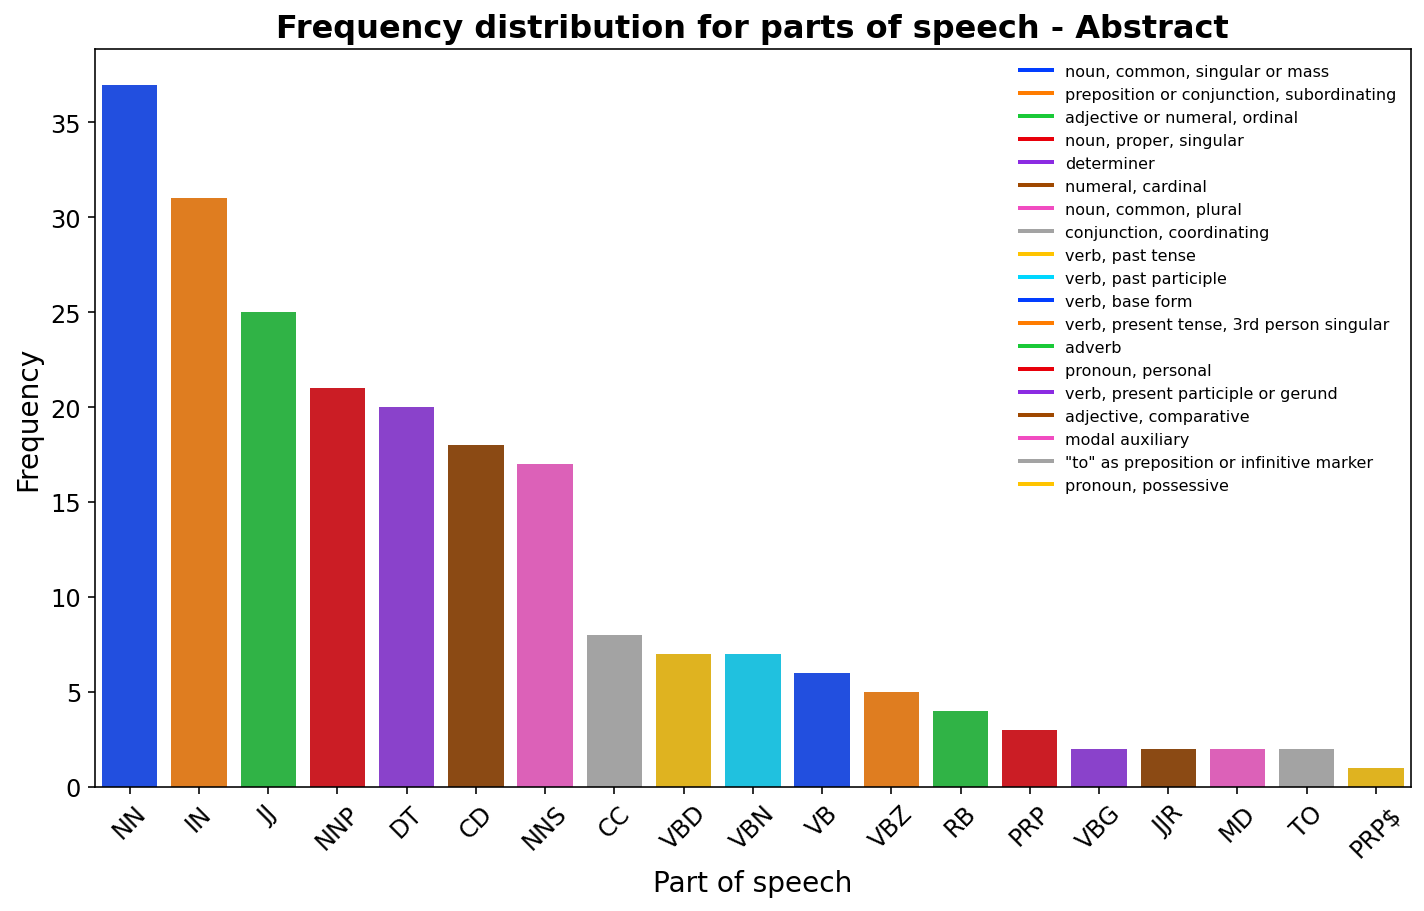

In [0]:
from nltk.data import load
tagdict = load('help/tagsets/upenn_tagset.pickle')
from textblob import TextBlob
blob = TextBlob(abstracts[0])
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_freq = pos_df.pos.value_counts()[0:20]
pos_desc = [tagdict[x][0] for x in pos_freq.index.values]
top_abs_pos_df = pd.DataFrame(np.column_stack([pos_freq.index.values, pos_desc, pos_freq.values]), 
                          columns=['pos', 'description', 'freq'])

f, ax = plt.subplots(figsize=(10, 7))

sns.barplot(x=top_abs_pos_df.pos, y=top_abs_pos_df.freq, palette="bright", ax=ax)
plt.xticks(fontsize=12, rotation=45);
plt.yticks(fontsize=12);
ax.set_ylabel("Frequency", fontsize=14);
ax.set_xlabel("Part of speech", fontsize=14);
ax.set_title("Frequency distribution for parts of speech - Abstract", fontsize=16, weight='bold')

colors = sns.color_palette("bright", n_colors=20)
desc = top_abs_pos_df.description.values
from matplotlib.lines import Line2D
patches = [Line2D([0], [0], color=_color, linewidth=2, linestyle='-') for _color in colors]
leg = plt.gca().legend(patches, desc, loc=0, frameon=True, fontsize=8, framealpha=1.0)
leg.get_frame().set_linewidth(0.0)

f.tight_layout(rect=[0, 0.03, 1, 0.95])

**Parts of speech distribution for the corresponding article**

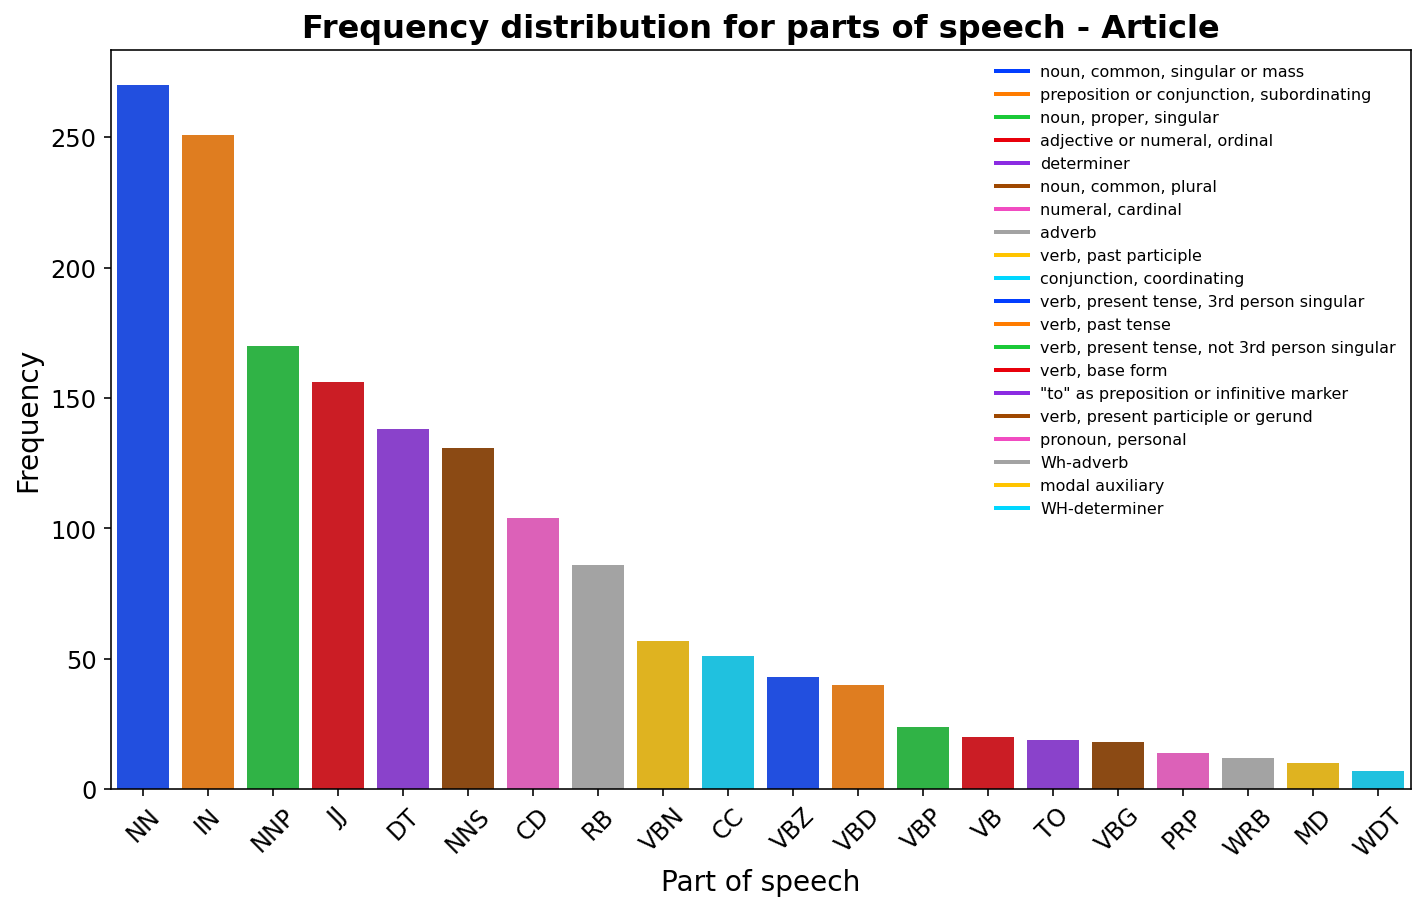

In [0]:
blob = TextBlob(articles_body[0])
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_freq = pos_df.pos.value_counts()[0:20]
pos_desc = [tagdict[x][0] for x in pos_freq.index.values]
top_body_pos_df = pd.DataFrame(np.column_stack([pos_freq.index.values, pos_desc, pos_freq.values]), 
                          columns=['pos', 'description', 'freq'])

f, ax = plt.subplots(figsize=(10, 7))

sns.barplot(x=top_body_pos_df.pos, y=top_body_pos_df.freq, palette="bright", ax=ax)
plt.xticks(fontsize=12, rotation=45);
plt.yticks(fontsize=12);
ax.set_ylabel("Frequency", fontsize=14);
ax.set_xlabel("Part of speech", fontsize=14);
ax.set_title("Frequency distribution for parts of speech - Article", fontsize=16, weight='bold')

colors = sns.color_palette("bright", n_colors=20)
desc = top_body_pos_df.description.values
from matplotlib.lines import Line2D
patches = [Line2D([0], [0], color=_color, linewidth=2, linestyle='-') for _color in colors]
leg = plt.gca().legend(patches, desc, loc=0, frameon=True, fontsize=8, framealpha=1.0)
leg.get_frame().set_linewidth(0.0)

f.tight_layout(rect=[0, 0.03, 1, 0.95])

## Prepare abstracts and articles for vectorization

The core task in text classification pipelines is data preparation to express the textual data as a numeric vector. The general pipeline begins by pre-processing or cleaning the text. This step typically includes tasks such as, lowercasing text, removing certain characters and/or character sequences, breaking the text into word tokens, lemmatization (remove word inflectional), and removing overly common words (called stop words). 

Run the following cell to setup the helper functions for text pre-processing.

In [0]:
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

tokenizer = ToktokTokenizer()
wordnet_lemmatizer = WordNetLemmatizer()
stopword_list = nltk.corpus.stopwords.words('english')

def lemmatize_text(text):
    s = " "
    t_l = []
    t_w = nltk.word_tokenize(text)
    for w in t_w:
        l_w = wordnet_lemmatizer.lemmatize(w, pos="v")
        t_l.append(l_w)
    text = s.join(t_l)
    return text

def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def clean_body(body):
    body = body.lower()
    pattern = r'[\-]'
    body = re.sub(pattern, ' ', body)
    pattern = r'[\/]'
    body = re.sub(pattern, ' ', body)
    pattern = r'[\(\[].*?[\)\]]'
    body = re.sub(pattern, '', body)
    pattern = r'[^a-zA-Z0-9_\s]'
    body = re.sub(pattern, '', body)
    body = lemmatize_text(body)
    body = remove_stopwords(body)
    return body

Run the next two cells to review an original article and the pre-processed/cleaned version of the same article.

In [0]:
articles_body[0]

Out[23]: 'Data on the "total number of COVID-19 cases per 1 million population" and "total number of COVID-19 deaths per 1 million population" of different countries were obtained from an online source. [1] Data on the "BCG policy, " "incidence of TB/1,000,000 population, " and the "income group according to World Bank data" of these countries were obtained from another online source. Countries with a total case fatality 20 (on the date of the study) were included. [3] The countries were divided into two groups: Group A containing the countries "where universal BCG policy is in practice at present" and Group B containing the countries "where universal BCG policy is not practiced at present. " We compared the "total number of COVID-19 cases per 1 million population" as well as the "total number of deaths per 1 million population" between Groups A and B to look for any statistical significance. Subsequently, we divided the countries with "no universal BCG policy" into two groups: Group C containing the countries where "universal BCG policy was previously present, but has now been stopped" and Group D containing the countries where "universal BCG policy was never present. " The number of COVID-19 cases per 1 million population in Group C and Group D was compared to look for any statistically significant difference. Similarly, the number of deaths per million was also compared between Groups C and D. Eventually, we grouped all the countries into two groups: The first group (Group E) comprising "countries where incidence of tuberculosis is ≤20/1,000,000, " i.e., countries with low incidence of tuberculosis and the second group (Group F) comprising nations "where the incidence of tuberculosis is >20/1,000,000, " i.e. countries with higher incidence of tuberculosis). We compared the "total number of COVID-19 cases per 1 million population" as well as the "total number of deaths per 1 million population" between Groups E and F. The data in the two groups were tested for statistical significance using the Mann-Whitney U-test. An online software was used to analyze the data available at http://www. statskingdom.com/170median_mann_whitney.html. At the time of the study, 50 countries had a total COVID-19 deaths of ≥20. Out of these, 21 countries do not have a universal BCG vaccination policy at present, whereas 29 countries have it. Out of the 21 countries with no universal BCG policy, 20 countries are from high-income group and one country is from upper middle-income group. Out of the 29 countries with universal BCG vaccination, 7 are from high income, 15 are from upper middle, and 7 are from lower middle-income group. The countries where universal BCG vaccination is not practiced have a mean COVID-19 positive cases of 1272.9 (standard deviation 1557.9) per 1 million population with a median of 795. The countries where universal BCG vaccination is practiced have a mean COVID-19 positive cases of 131.1 (standard deviation 208.7) per 1 million population with a median of 40. The difference is statistically significant (P < 0.001) [ Figure 1a ]. The countries where universal BCG vaccination is not practiced have a mean COVID-19 deaths of 80.7 (standard deviation 180.8) per 1 million population with a median of 18. The countries where universal BCG vaccination is practiced have a mean COVID-19 positive deaths of 4 (standard deviation 7.6) per 1 million population with a median of 1. The difference is statistically significant (P < 0.001) [ Figure 1b ]. Out of the 21 countries with no universal BCG vaccinations policy, 15 countries had universal BCG vaccination policy in the past but have stopped the practice at present (Group C); five countries never had universal BCG (Group D) and data were not available about one country (San Marino). The difference in the "number of cases per 1 million" between Group C and Group D was not statistically significant (P = 0.8). Similarly, the difference in the "number of deaths per 1 million" between Groups 

In [0]:
clean_body(articles_body[0])

Out[24]: 'data total number covid 19 case per 1 million population total number covid 19 deaths per 1 million population different countries obtain online source data bcg policy incidence tb 1000000 population income group accord world bank data countries obtain another online source countries total case fatality 20 include countries divide two group group contain countries universal bcg policy practice present group b contain countries universal bcg policy practice present compare total number covid 19 case per 1 million population well total number deaths per 1 million population group b look statistical significance subsequently divide countries universal bcg policy two group group c contain countries universal bcg policy previously present stop group contain countries universal bcg policy never present number covid 19 case per 1 million population group c group compare look statistically significant difference similarly number deaths per million also compare group c eventually group countries two group first group comprise countries incidence tuberculosis 20 1000000 ie countries low incidence tuberculosis second group comprise nations incidence tuberculosis 20 1000000 ie countries higher incidence tuberculosis compare total number covid 19 case per 1 million population well total number deaths per 1 million population group e f data two group test statistical significance use mann whitney u test online software use analyze data available http www statskingdomcom 170median_mann_whitneyhtml time study 50 countries total covid 19 deaths 20 21 countries universal bcg vaccination policy present whereas 29 countries 21 countries universal bcg policy 20 countries high income group one country upper middle income group 29 countries universal bcg vaccination 7 high income 15 upper middle 7 lower middle income group countries universal bcg vaccination practice mean covid 19 positive case 12729 per 1 million population median 795 countries universal bcg vaccination practice mean covid 19 positive case 1311 per 1 million population median 40 difference statistically significant countries universal bcg vaccination practice mean covid 19 deaths 807 per 1 million population median 18 countries universal bcg vaccination practice mean covid 19 positive deaths 4 per 1 million population median 1 difference statistically significant 21 countries universal bcg vaccinations policy 15 countries universal bcg vaccination policy past stop practice present five countries never universal bcg data available one country difference number case per 1 million group c group statistically significant similarly difference number deaths per 1 million group c also statistically significant 50 countries include study incidence tuberculosis 20 1000000 population 29 countries 20 1000000 population 21 countries difference total number case per million population group e group f statistically significant besides total number deaths per million population group e f also statistically significant study show significantly lower number case well deaths countries universal bcg policy practice hence possibly conclude bcg vaccination provide cross protection covid 19 however detail study epidemiological parameters countries universal bcg vaccination policy past reveal enigmatic result earliest stop universal bcg sweden stop 1975 mean almost people age 45 years sweden receive bcg vaccination childhood fact countries stop universal bcg vaccination around 1990s mean people age around 30 years receive bcg vaccination childhood france one last countries stop universal bcg year 2007 every french citizen 13 years age must receive bcg vaccination even france rank 4 th total number case per million population study also show total number case well total number deaths per million significantly lower countries high incidence tuberculosis must remember countries high incidence tuberculosis practice universal vaccination countries low incidence tuberculosis stop give universal bcg f

Run the following cell to preprocess/clean all abstracts and articles in our collections.

In [0]:
abstracts_cleaned = [clean_body(abstract) for abstract in abstracts]
articles_body_cleaned = [clean_body(article_body) for article_body in articles_body]

### Distribution of cleaned Abstract and Article Word Lengths

Run the next two cells to review the cleaned abstract word length distribution and compare that with the raw abstract word length distribution from above. Observe that in comparison, the cleaned abstract distribution is closer to normal distribution and as a result both the skewness and kurtosis metrics are lower compared to the raw abstract distribution.

Out[26]:

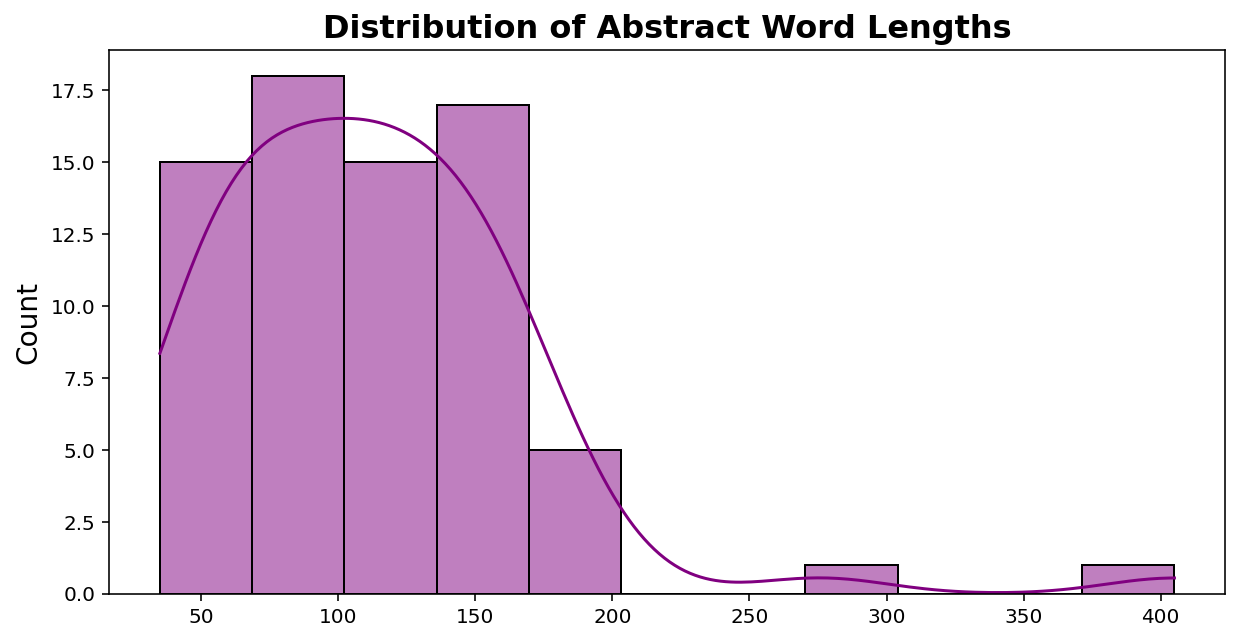

Text(0.5, 1.0, 'Distribution of Abstract Word Lengths')

In [0]:
abstract_nwords = list(map(len, map(nltk.word_tokenize, abstracts_cleaned)))
f, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=abstract_nwords, ax=ax, kde=True, color='purple')
ax.set_ylabel("Count", fontsize=14);
ax.set_title("Distribution of Abstract Word Lengths", fontsize=16, weight='bold')

In [0]:
print(s_stats.describe(abstract_nwords))

DescribeResult(nobs=72, minmax=(35, 405), mean=112.88888888888889, variance=3377.508607198748, skewness=1.980038866430518, kurtosis=7.569790271559514)

Run the next two cells to review the cleaned article word length distribution. Observe that the majority of the articles are 1000 words or less.

Out[28]:

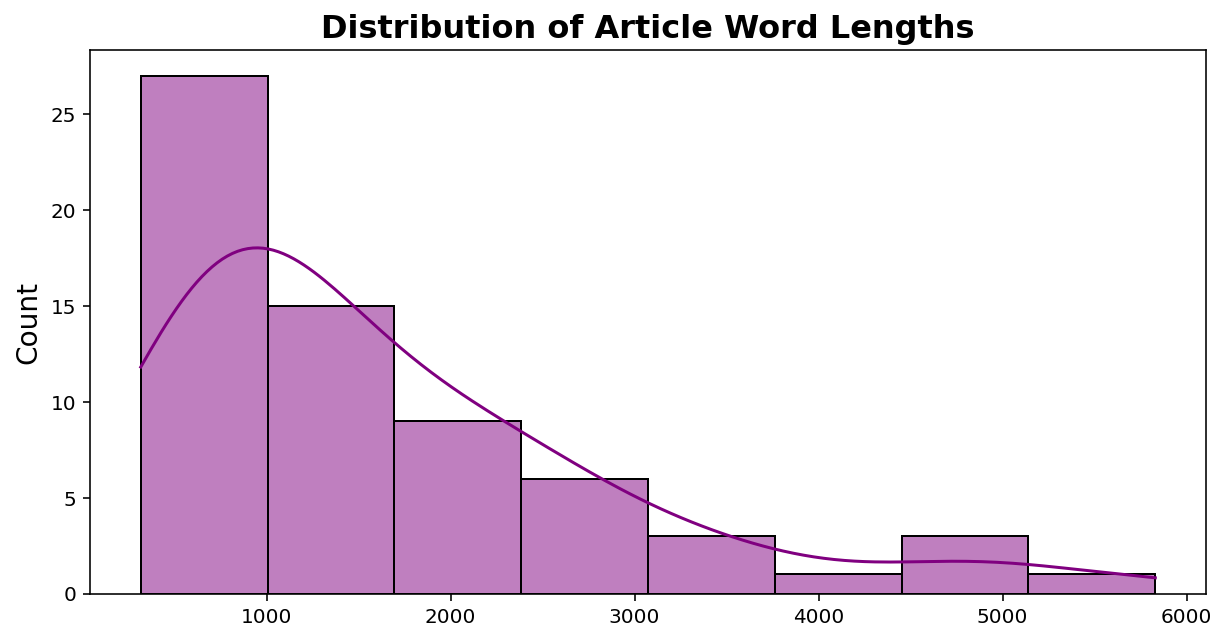

Text(0.5, 1.0, 'Distribution of Article Word Lengths')

In [0]:
articles_nwords = list(map(len, map(nltk.word_tokenize, articles_body_cleaned)))
f, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=articles_nwords, ax=ax, kde=True, color='purple')
ax.set_ylabel("Count", fontsize=14);
ax.set_title("Distribution of Article Word Lengths", fontsize=16, weight='bold')

In [0]:
print(s_stats.describe(articles_nwords))

DescribeResult(nobs=65, minmax=(316, 5830), mean=1663.2923076923078, variance=1509266.3350961537, skewness=1.464340161139294, kurtosis=1.8270738807617963)

### Top 20 trigrams frequency distribution

Trigrams are a group of three consecutive written words. Next, we will look at the trigram distributions across all cleaned abstracts and cleaned articles.

Run the following cell to setup the helper function to compute an plot the top 20 trigrams.

In [0]:
from nltk.probability import FreqDist
from nltk.util import ngrams

def freq_trigram(x, terms = 20, title="Top 20 Trigrams Frequency Distribution"): 
    agg_words = ' '.join([text for text in x]) 
    unigrams = agg_words.split() 
    trigrams = ngrams(unigrams, 3)
    all_words = [' '.join(three_words) for three_words in trigrams]
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'word_count':list(fdist.values())}) 
  
    # selecting top n most frequent words 
    #d = words_df.nlargest(columns="word_count", n = terms)
    d = words_df.sort_values(by=['word_count', 'word'], ascending=False).head(terms)

    f, ax = plt.subplots(figsize=(10, 7))
    sns.barplot(y=d.word, x=d.word_count, palette="deep", ax=ax)
    ax.set_xlabel("Frequency", fontsize=14);
    ax.yaxis.label.set_visible(False)
    ax.set_title(title, fontsize=16, weight='bold')
    f.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Run the next two cells to plot the top 20 trigrams across all abstracts and all articles. Observe that the top trigrams are remarkably similar between the two corpuses.

You will observe common trigrams such as:
- sars cov 2
- covid 19 pandemic
- sever acute respiratory
- personal protective equipment
- intensive care unit

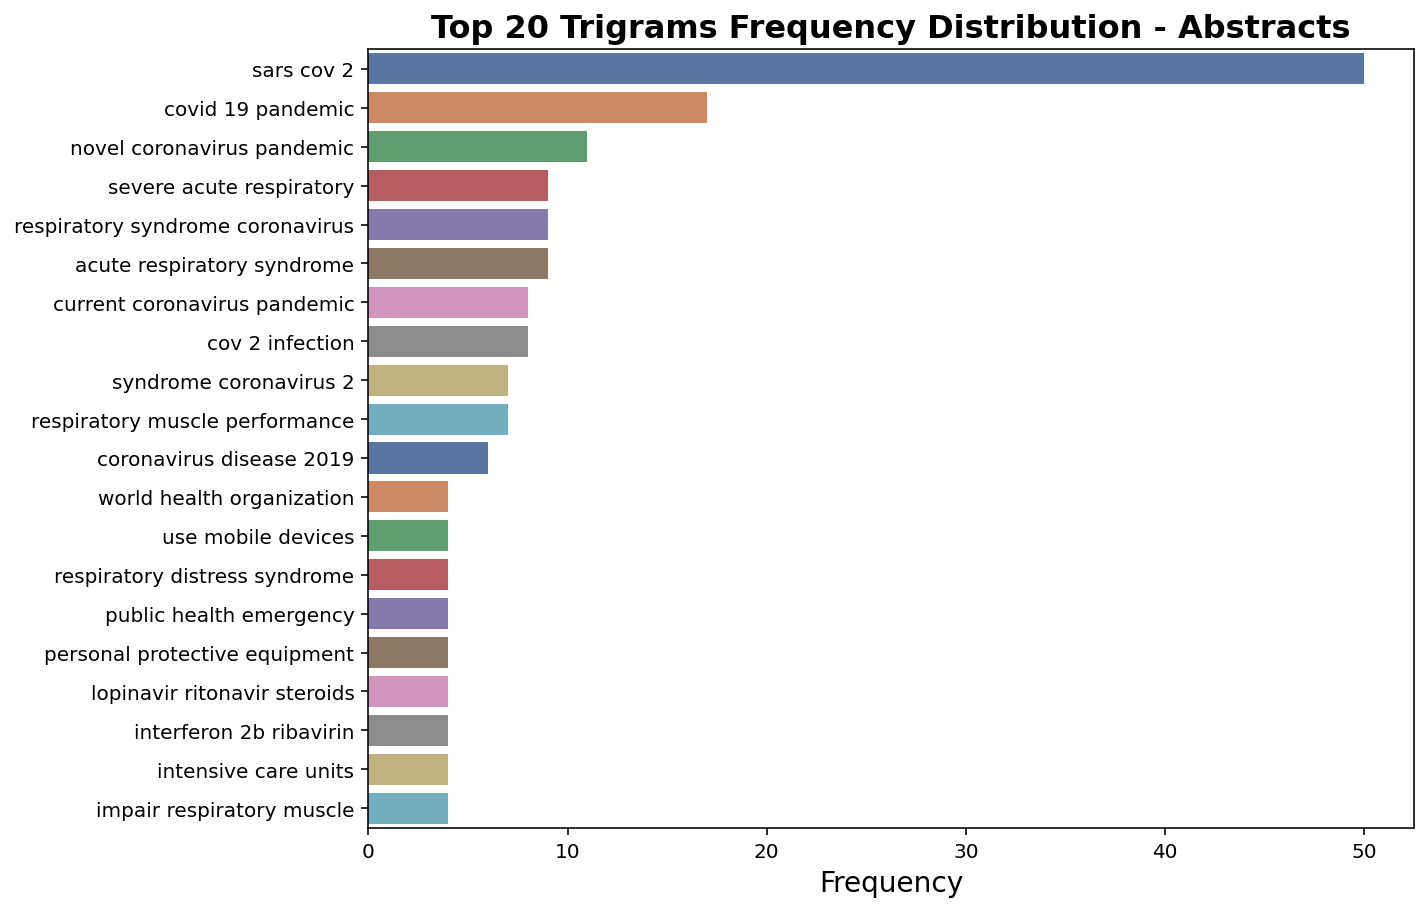

In [0]:
freq_trigram(abstracts_cleaned, title = "Top 20 Trigrams Frequency Distribution - Abstracts")

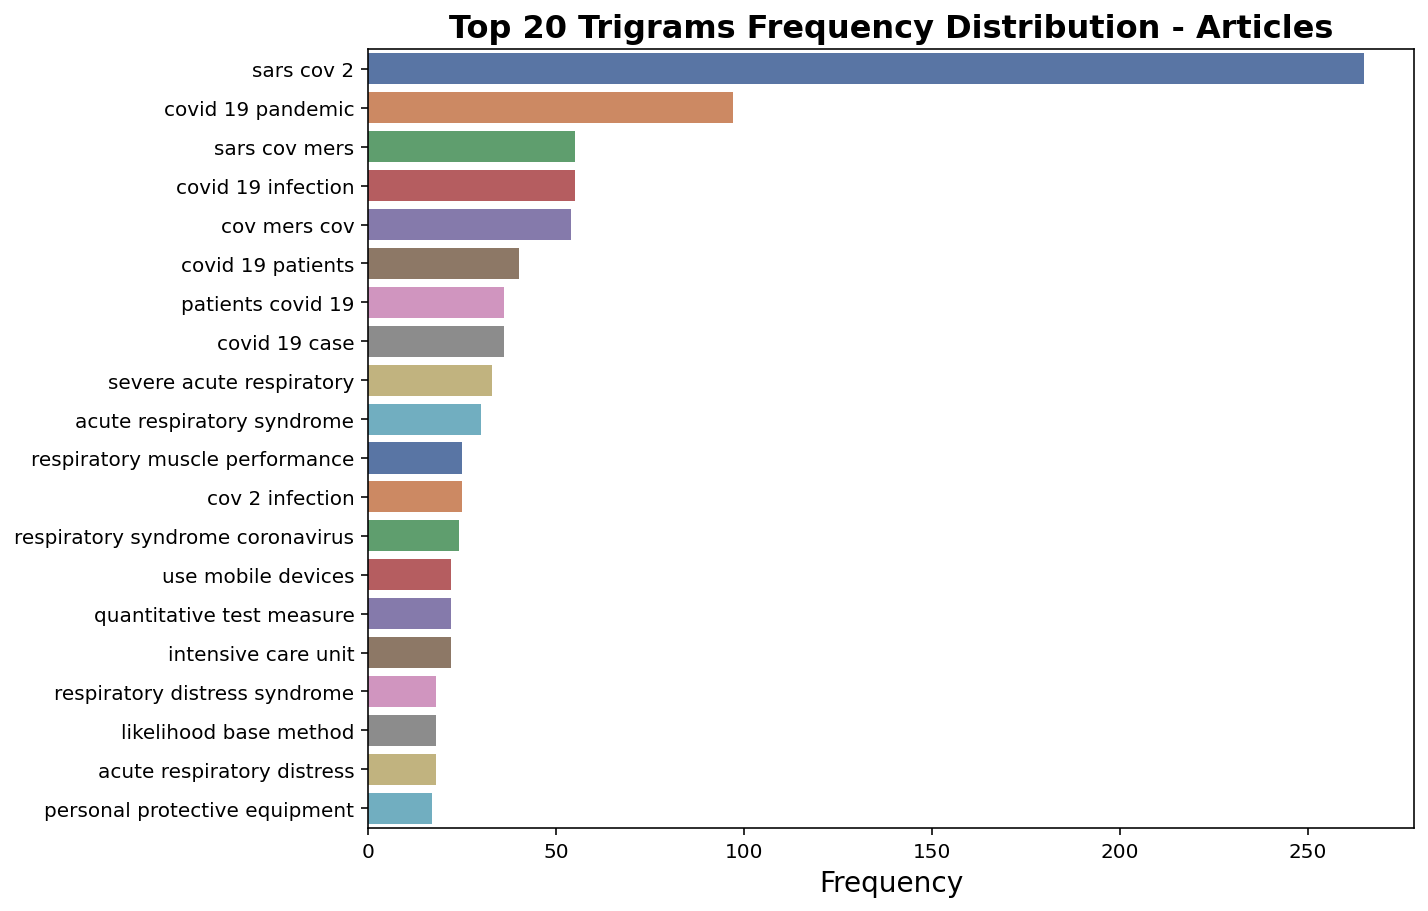

In [0]:
freq_trigram(articles_body_cleaned, title = "Top 20 Trigrams Frequency Distribution - Articles")

## Discover Duplicate and Similar Articles

Given the similarities between abstracts and articles as seen in the frequency distributions of both parts of speech and trigrams, we would like to evaluate if abstracts are sufficient for text classification problems such identifying duplicate and similar articles.

### Vectorize cleaned abstracts

In machine learning, when you are working with text, as part of text vectorization, you convert words or sentences in text into numeric vector representation. One of the common vectorization approaches in text classification is the Term Frequency-Inverse Document Frequency (TF-IDF) vectorization. The approach of TF-IDF is to give less important to words that are common in most documents and giver higher importance to words that appears more frequently in fewer documents. Thus TF-IDF assigns weights to words that signify their relevance in the documents.

Run the following cell to vectorize the cleaned abstracts using the TF-ID vectorizer.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', norm='l2').fit_transform(abstracts_cleaned)

### Discover duplicate articles

The TF-IDF vector is L2 normalized. Thus, the cosine similarity between any two vectors is simply the dot product of the two vectors. Here we find the cosine similarity between each abstract’s vector and identify abstract pairs that have cosine similarity of >= 0.9.

In [0]:
pairwise_similarity = tfidf * tfidf.T
similarity_array = pairwise_similarity.toarray()
np.fill_diagonal(similarity_array, 0)
similarity_cutoff = 0.9
current_doc_index = -1
child_indexes = []
for row in similarity_array:
    current_doc_index = current_doc_index + 1
    if current_doc_index not in child_indexes:
        dupes = np.nonzero(np.around(row, 2) >= similarity_cutoff)[0]
        if (len(dupes) > 0):
            for dupe in dupes:
                similarity = similarity_array[current_doc_index][dupe]
                print('abstract {} is similar to {} with similarity score of: {}'.format(current_doc_index, 
                                                                                   dupe, 
                                                                                   similarity))
                child_indexes.append(dupe)

abstract 21 is similar to 28 with similarity score of: 0.9999999999999996
abstract 34 is similar to 61 with similarity score of: 0.9972329539254359

This shows that abstract #21 is almost identical to abstract #28. Next, we will print these two abstracts and confirm that they are indeed identical or duplicates.

In [0]:
print(abstracts[21])

Abstract In the setting of the current novel coronavirus pandemic, this document has been generated to provide guiding statements for the adult cardiac surgeon to consider in a rapidly evolving national landscape. Acknowledging the risk for a potentially prolonged need for cardiac surgery procedure deferral, the authors have created this proposed template for physicians and interdisciplinary teams to consider in protecting their patients, institution and their highly specialized cardiac surgery team. In addition, recommendations on the transition from traditional in-person patient assessments and outpatient follow-up are provided. Lastly, we advocate that the cardiac surgeon must continue to serve as leaders, experts, and relevant members of our medical community, shifting our role as necessary in this time of need.

In [0]:
print(abstracts[28])

Abstract In the setting of the current novel coronavirus pandemic, this document has been generated to provide guiding statements for the adult cardiac surgeon to consider in a rapidly evolving national landscape. Acknowledging the risk for a potentially prolonged need for cardiac surgery procedure deferral, the authors have created this proposed template for physicians and interdisciplinary teams to consider in protecting their patients, institution and their highly specialized cardiac surgery team. In addition, recommendations on the transition from traditional in-person patient assessments and outpatient follow-up are provided. Lastly, we advocate that the cardiac surgeon must continue to serve as leaders, experts, and relevant members of our medical community, shifting our role as necessary in this time of need.

**Can you print and confirm that abstract #34 and #61 are also identical/duplicates?**

### Discover similar articles

Next we will try to discover articles are a different but similar in some fashion. We will use the same technique as above; expect this time we will look for abstracts with cosine similarity scores >=0.2 and < 0.9.

In [0]:
similarity_cutoff_min = 0.2
similarity_cutoff_max = 0.9
current_doc_index = -1
filtered_indexes = []
for row in similarity_array:
    current_doc_index = current_doc_index + 1
    if current_doc_index not in child_indexes:
        dupes = np.nonzero((np.around(row, 2) >= similarity_cutoff_min) & 
                           (np.around(row, 2) < similarity_cutoff_max))[0]
        if (len(dupes) > 0):
            filtered_indexes.append(current_doc_index)
            for dupe in dupes:
                filtered_indexes.append(dupe)

abstracts_filtered = [abstracts[i] for i in set(filtered_indexes)]
abstracts_cleaned_filtered = [abstracts_cleaned[i] for i in set(filtered_indexes)]
tfidf = TfidfVectorizer(stop_words='english').fit_transform(abstracts_cleaned_filtered)
corr = (tfidf * tfidf.T).toarray()

### Visualize the similarity correlation matrix for similar articles

Note that above we created a new filtered collection of abstracts (`abstracts_filtered`) that fall in the similarity score range of >=0.2 and <0.9. This will allow us to visualize the similarity correlation matrix for only those qualifying abstracts.

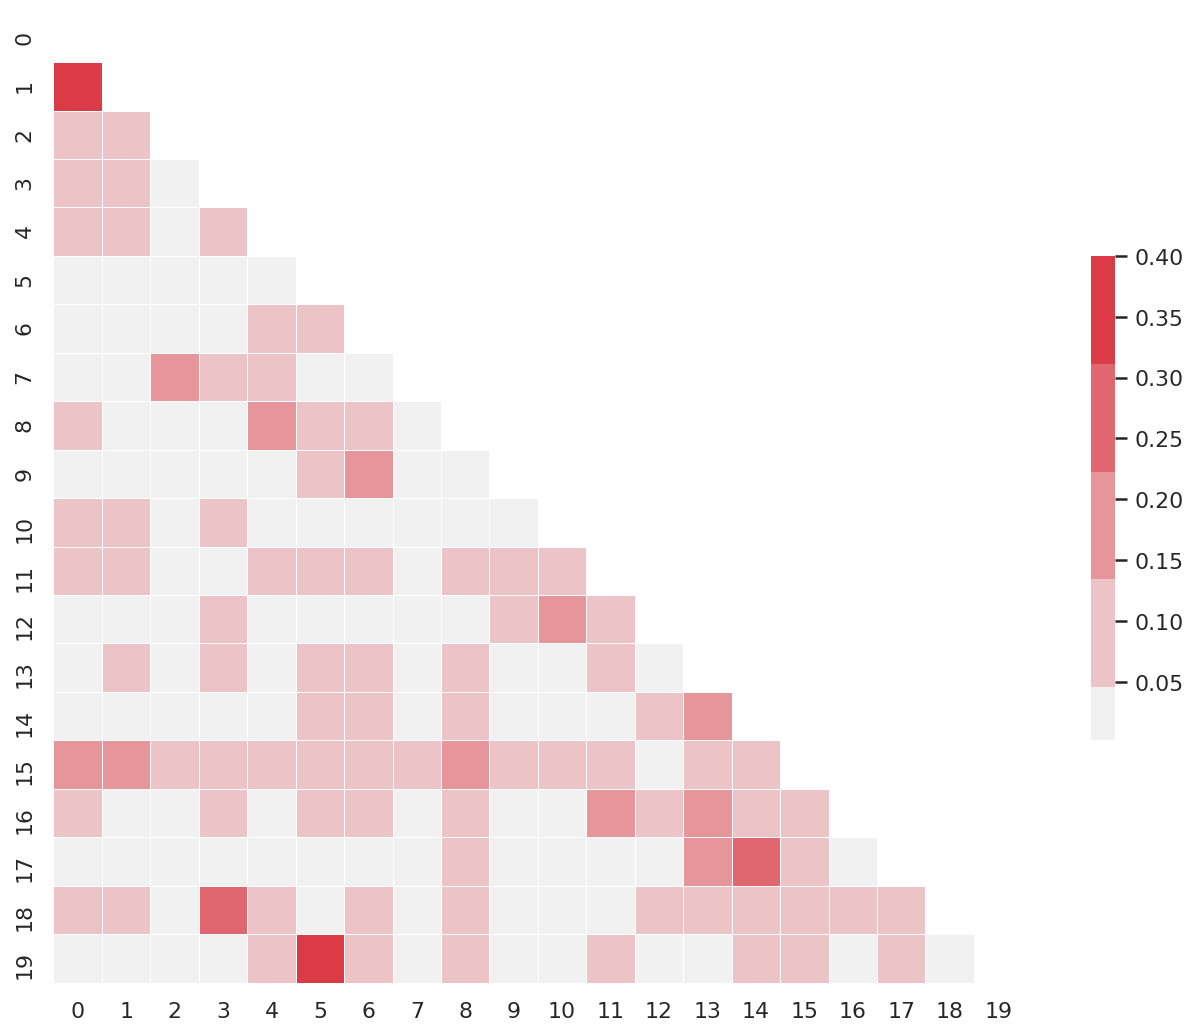

In [0]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, n=9)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.4, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

f.tight_layout(rect=[0, 0.03, 1, 0.95])

Based on the above heat map abstracts **(0 and 1)** and **(5 and 19)** have the highest similarity score.

Next, we will print abstracts **5 and 19** from `abstracts_filtered` collection and confirm if they are similar in nature.

In [0]:
abstracts_filtered[5]

Out[39]: 'BACKGROUND: The 2019 coronavirus pandemic is a current global health crisis. Many chiropractic institutions, associations, and researchers have stepped up at a time of need. However, a subset of the chiropractic profession has claimed that spinal manipulative therapy (SMT) is clinically effective in improving one’s immunity, despite the lack of supporting scientific evidence. These unsubstantiated claims contradict official public health policy reflecting poorly on the profession. The aim of this commentary is to provide our perspective on the claims regarding SMT and clinically relevant immunity enhancement, drawing attention to the damaging ramifications these claims might have on our profession’s reputation. MAIN TEXT: The World Federation of Chiropractic released a rapid review demonstrating the lack of clinically relevant evidence regarding SMT and immunity enhancement. The current claims contradicting this review carry significant potential risk to patients. Furthermore, as a result of these misleading claims, significant media attention and public critiques of the profession are being made. We believe inaction by regulatory bodies will lead to confusion among the public and other healthcare providers, unfortunately damaging the profession’s reputation. The resulting effect on the reputation of the profession is greatly concerning to us, as students. CONCLUSION: It is our hope that all regulatory bodies will protect the public by taking appropriate action against chiropractors making unfounded claims contradicting public health policy. We believe it is the responsibility of all stakeholders in the chiropractic profession to ensure this is carried out and the standard of care is raised. We call on current chiropractors to ensure a viable profession exists moving forward.'

In [0]:
abstracts_filtered[19]

Out[40]: 'BACKGROUND: In the midst of the coronavirus pandemic, the International Chiropractors Association (ICA) posted reports claiming that chiropractic care can impact the immune system. These claims clash with recommendations from the World Health Organization and World Federation of Chiropractic. We discuss the scientific validity of the claims made in these ICA reports. MAIN BODY: We reviewed the two reports posted by the ICA on their website on March 20 and March 28, 2020. We explored the method used to develop the claim that chiropractic adjustments impact the immune system and discuss the scientific merit of that claim. We provide a response to the ICA reports and explain why this claim lacks scientific credibility and is dangerous to the public. More than 150 researchers from 11 countries reviewed and endorsed our response. CONCLUSION: In their reports, the ICA provided no valid clinical scientific evidence that chiropractic care can impact the immune system. We call on regulatory authorities and professional leaders to take robust political and regulatory action against those claiming that chiropractic adjustments have a clinical impact on the immune system.'

**Both articles talk about the claims that chiropractic care helps improve the immune system that is important at the time of the global coronavirus pandemic. Furthermore, both articles talk about how these claims are unfounded and lacks scientific credibility.**

**Can you print and confirm that abstract #0 and #1 are also similar?**

Remember to use the `abstracts_filtered` collection.

In summary, we can see that the pipeline of preprocessing/cleaning the abstract text, and vectorizing the abstract text using the L2 normalized TF-IDF vectorizer was effective in certain document classification tasks such as identifying duplicate articles and also identifying similar articles from the underlying corpus.